In [86]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import gaussian_kde
import matplotlib
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='cm')

# Helper Functions

In [87]:
def even_spaced(sample, n=50, fudge=0.05):
    dist = np.max(sample) - np.min(sample)
    minimum = np.min(sample) - dist*fudge
    maximum = np.max(sample) + dist*fudge
    return np.linspace(minimum, maximum, n)

In [88]:
def component_plot(samp, axes, cmap, bw=None, thin=1):
    n = samp.shape[1]
    # first plot the diagonal
    for i in range(n):
        ax = axes[i,i]
        sample = samp[::thin,i]
        x = even_spaced(sample)
        kde = gaussian_kde(sample.T, bw)
        handle, = ax.plot(x, kde(x), c=matplotlib.cm.get_cmap(cmap)(0.5))
        
    # plot below diagonal
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[j,i]
            sample = samp[::thin, [i,j]]
            kde = gaussian_kde(sample.T, bw)
            
            x0 = even_spaced(sample[:,0])
            x1 = even_spaced(sample[:,1])
            
            x, y = np.meshgrid(x0, x1)
            z = kde(np.column_stack([x.ravel(), y.ravel()]).T).reshape(x.shape)
            ax.contour(x, y, z, cmap=cmap)
    
    # blank above diagonal
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i, j]
            ax.set_axis_off()
    return handle     

In [89]:
def component_plot_truth(truth, axes, color='black'):
    n = truth.shape[0]
    for i in range(n):
        ax = axes[i,i]
        ax.axvline(truth[i], linestyle='--', color=color)
        
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[j,i]
            ax.scatter(truth[i], truth[j], marker='x', color=color, zorder=1000)
    return mlines.Line2D([], [], color=color, marker='x', linestyle='--')

In [90]:
def component_plot_set_font_sizes(axes, fontsize):
    for a in axes.ravel():
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
        for tick in a.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize)

In [91]:
def component_plot_axes_off(axes):
    for i in range(1, len(axes)):
        for j in range(0, len(axes)):
            ax = axes[j,i]
            ax.yaxis.set_major_locator(plt.NullLocator())

    for i in range(0, len(axes)):
        for j in range(0, len(axes)-1):
            ax = axes[j,i]
            ax.xaxis.set_major_locator(plt.NullLocator())

In [92]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tricontourf(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

# Static Recovery: Principal Components

Static recovery problem (1 fixed time point). Fix all details of the inverse problem (IP) except the numerical solver. Comparison of the full posteriors obtained under 

* Collocation (Co)
* Probabilistic meshless method (PMM)
* EIDORS (a benchmark solve, on a fine grid)

Consider the true field, parametrised in terms of the first (say) 5 principle components of the EIDORS posterior. Call these true values $\theta_1^0$,...,$\theta_5^0$. Show a plot-matrix of $\theta_i$ vs $\theta_j$, mark on the true point $(\theta_i^0,\theta_j^0)$ and plot the posterior contours obtained from Co (coarse grid), PMM (coarse grid) and EIDORS (one colour for each).
With luck, we should see that Co contours do not cover EIDORS contours. PMM should be centred close to Co but have a larger variance which covers EIDORS.
Then repeat with Co (fine grid), PMM (fine grid) and EIDORS. At this point all 3 sets of contours should now coincide.
The aim here is to show that accounting for the impact of numerical error on the inferences is important.

First question is how to represent 'principal components' here. We need to project the posterior onto some vectors and plot the distribution over those vectors. So maybe use a Gaussian approximation, then project the samples through that transformation and see what happens?

In [93]:
burn = 25000
n_pcs = 5
frame = 14
n_pts_coarse = 8
n_pts_ref = 12

## Generate the PCs

In [94]:
ref_name = 'results/static_recovery_f{}_n={}_collocation/'.format(frame, n_pts_ref)
field_pts = np.load(os.path.join(ref_name, 'field_pts.npy'))
ref_samples = np.load(os.path.join(ref_name, 'results.npy'))[burn:, :]
pmm_name_coarse = 'results/static_recovery_f{}_n={}/'.format(frame, n_pts_coarse)
pmm_samples_coarse = np.load(os.path.join(pmm_name_coarse, 'results.npy'))[burn:, :]
coll_name_coarse = 'results/static_recovery_f{}_n={}_collocation/'.format(frame, n_pts_coarse)
coll_samples_coarse = np.load(os.path.join(coll_name_coarse, 'results.npy'))[burn:, :]

#ref_samples = np.exp(ref_samples)
#pmm_samples_coarse = np.exp(pmm_samples_coarse)
#coll_samples_coarse = np.exp(coll_samples_coarse)

In [95]:
ref_cov = np.cov(ref_samples.T)

In [96]:
gray_cmap = mcolors.LinearSegmentedColormap.from_list('grays_trunc', [(0.7, 0.7, 0.7), (0.1, 0.1, 0.1)])

In [97]:
evals, evecs = np.linalg.eig(ref_cov)
evecs = evecs[:, 0:n_pcs]

In [98]:
truth = np.dot(np.mean(ref_samples, axis=0), evecs) # get the projections onto the eigenvectors
truth_projection = np.dot(ref_samples, evecs)
pmm_projection_coarse = np.dot(pmm_samples_coarse, evecs)
coll_projection_coarse = np.dot(coll_samples_coarse, evecs)

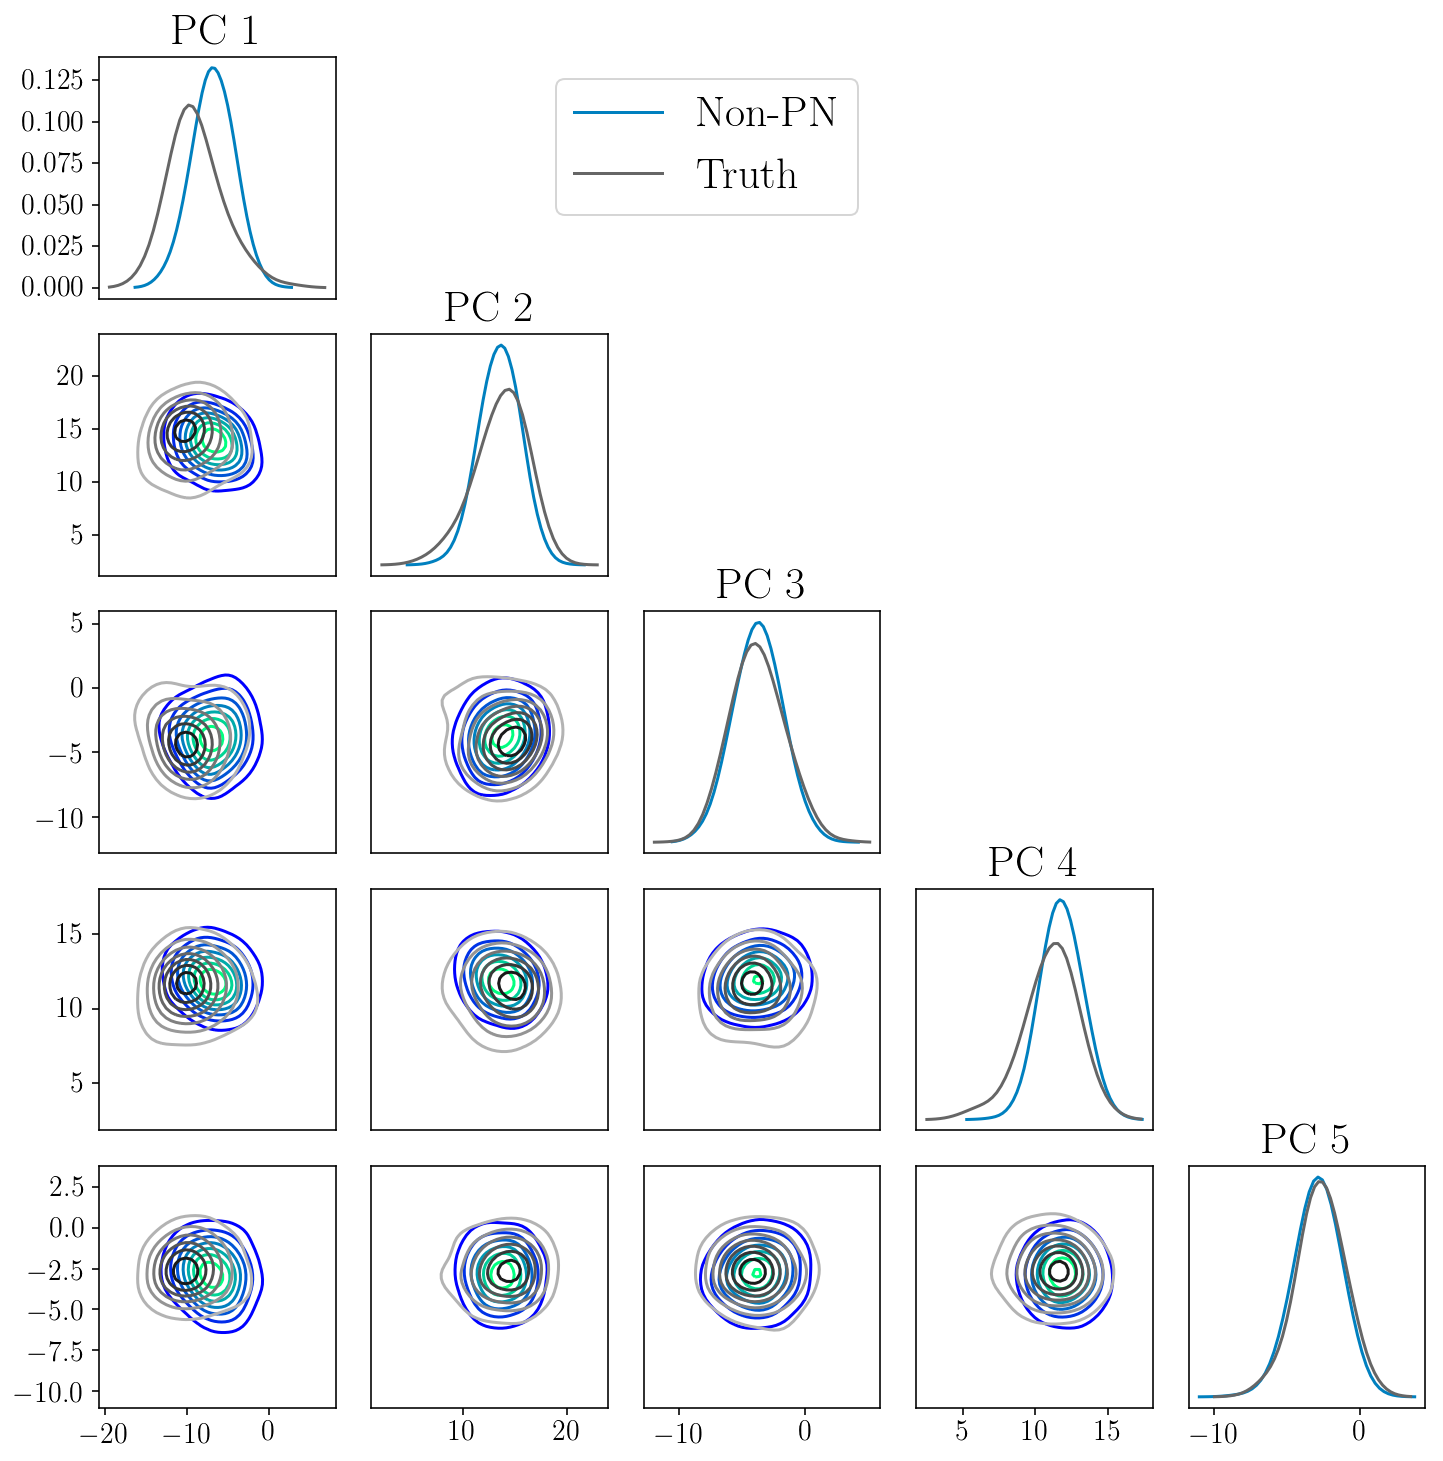

In [99]:
bw = 0.4
thin = 10
fig, axes = plt.subplots(evecs.shape[1], evecs.shape[1], False, False, figsize=(10,10))
#h_pmm = component_plot(pmm_projection_coarse, axes, cmap='autumn', bw=bw, thin=thin)
h_coll = component_plot(coll_projection_coarse, axes, cmap='winter', bw=bw, thin=thin)
#h_truth = component_plot_truth(truth, axes)
h_truth = component_plot(truth_projection, axes, cmap=gray_cmap, bw=bw, thin=thin)
component_plot_axes_off(axes)
component_plot_set_font_sizes(axes, 14)
plt.tight_layout()
#axes[0, 1].legend([h_pmm, h_coll, h_truth], ['PMM', 'Collocation', 'Reference'])
axes[0, 2].legend([h_coll, h_truth], ['Non-PN', 'Truth'], fontsize=22)
for i in range(len(axes)):
    axes[i,i].set_title('PC {}'.format(i+1), fontsize=22)
    
plt.savefig('figures/failure_illustration_n={}.pdf'.format(n_pts_coarse), bbox_inches='tight', transparent=True)